<a href="https://colab.research.google.com/github/MWesner3344/DSCI-591/blob/main/DSCI_592.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Unsupervised Image Segmentation


### Data Science Capstone Project II

### 1-25-21


**Authors:**
Avani Jain,
Michael Wesner

#### Load data and libraries

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from skimage.transform import rescale, resize
from skimage import io


In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
## Need to manually load kaggle.json file first
!cp /kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat '/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset
!ls
!unzip /content/semantic-drone-dataset.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
sample_data
unzip:  cannot find or open /content/semantic-drone-dataset.zip, /content/semantic-drone-dataset.zip.zip or /content/semantic-drone-dataset.zip.ZIP.


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: flatbuffers, termcolor, opt-einsum, tensorflow-estimator, astunparse, protobuf, tensorboard, gast, wheel, keras-preprocessing, absl-py, google-pasta, numpy, h5py, six, typing-extensions, wrapt, grpcio
Required-by: fancyimpute


### Pet Dataset

In [ ]:
(pet_train, pet_test), pet_info = tfds.load('oxford_iiit_pet:3.*.*', split=['train', 'test'], shuffle_files=True, with_info=True)
assert isinstance(pet_train, tf.data.Dataset)
assert isinstance(pet_test, tf.data.Dataset)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCBOF61/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCBOF61/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
pet_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
iterator = pet_train.__iter__()
next_element = iterator.get_next()
print(next_element)

{'file_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Birman_125.jpg'>, 'image': <tf.Tensor: shape=(500, 334, 3), dtype=uint8, numpy=
array([[[59, 53, 53],
        [59, 53, 53],
        [58, 53, 50],
        ...,
        [78, 76, 79],
        [77, 75, 78],
        [76, 74, 77]],

       [[60, 54, 54],
        [62, 56, 56],
        [58, 53, 50],
        ...,
        [80, 78, 81],
        [79, 77, 80],
        [78, 76, 79]],

       [[61, 55, 55],
        [63, 57, 57],
        [58, 53, 50],
        ...,
        [80, 80, 82],
        [78, 78, 80],
        [77, 77, 79]],

       ...,

       [[54, 53, 51],
        [54, 53, 51],
        [55, 54, 52],
        ...,
        [15, 15, 15],
        [11, 13, 12],
        [ 3,  7,  6]],

       [[52, 51, 49],
        [53, 52, 50],
        [55, 54, 52],
        ...,
        [21, 21, 21],
        [19, 21, 20],
        [13, 15, 14]],

       [[52, 51, 49],
        [53, 52, 50],
        [55, 54, 52],
        ...,
        [17, 17, 17],
        [16, 

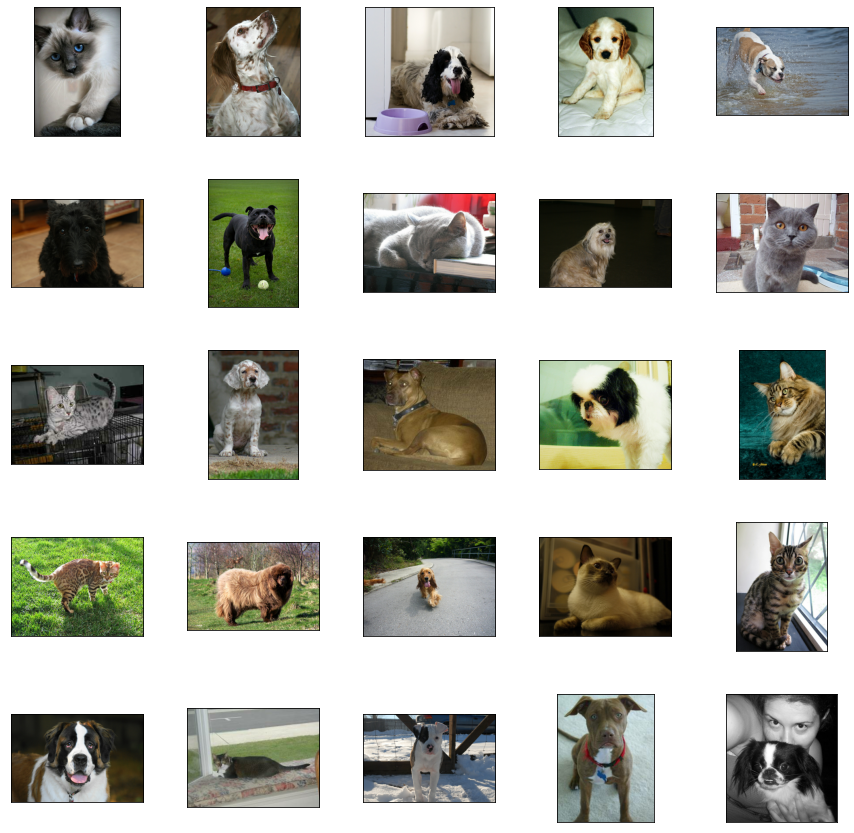

In [ ]:
fig = tfds.show_examples(pet_train, pet_info, rows = 5, cols = 5, image_key = 'image')

*   **Class 1 : Pixel belonging to the pet.**
*   **Class 2 : Pixel bordering the pet.**
*   **Class 3 : None of the above/ Surrounding pixel.**

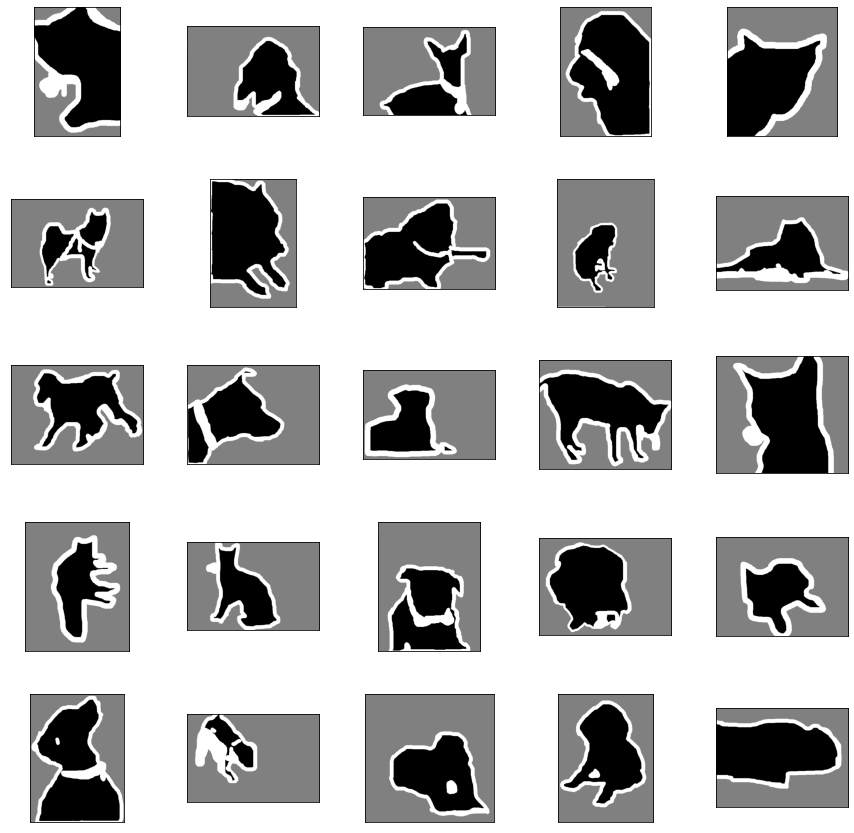

In [ ]:
fig = tfds.show_examples(pet_train, pet_info, rows = 5, cols = 5, image_key = 'segmentation_mask')

In [ ]:
pet_df = tfds.as_dataframe(pet_train, pet_info)
pet_df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          3680 non-null   object
 1   image              3680 non-null   object
 2   label              3680 non-null   int64 
 3   segmentation_mask  3680 non-null   object
 4   species            3680 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 143.9+ KB


### Drone Images Dataset

In [ ]:
img_dir = '/content/dataset/semantic_drone_dataset/original_images/'

img_df = pd.DataFrame(columns=['file', 'img', 'img_mask', 'rgb_mask'])

# load image data into a dataframe
k=0
for filename in os.listdir(img_dir):
    img_df.loc[k, 'file'] = filename
    img_df.loc[k, 'img'] = resize(io.imread(img_dir + filename), (600, 400, 3), anti_aliasing=True)
    k=k+1

FileNotFoundError: ignored

In [ ]:
img_df.head()

In [ ]:
label_dir = '/content/dataset/semantic_drone_dataset/label_images_semantic/'

k=0
for filename in os.listdir(label_dir):
    img_df.loc[k, 'img_mask'] = resize(io.imread(label_dir + filename), (600, 400, 1), anti_aliasing=True)
    k=k+1

In [ ]:
img_df.head()

In [ ]:
label_dir = '/content/RGB_color_image_masks/RGB_color_image_masks/'

k=0
for filename in os.listdir(label_dir):
    img_df.loc[k, 'rgb_mask'] = resize(io.imread(label_dir + filename), (600, 400, 3), anti_aliasing=True)
    k=k+1

In [ ]:
img_df.head()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'RGB Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
display([img_df['img'][0], img_df['img_mask'][1], img_df['rgb_mask'][1]])

### Cache pet dataset

In [ ]:
def normalize(input_image, input_mask):
      input_image = tf.cast(input_image, tf.float32) / 255.0
      input_mask -= 1
      return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):

  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = pet_info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = pet_train.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = pet_test.map(load_image_test)

In [ ]:
pet_train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
pet_train_dataset = pet_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
pet_test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display1(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for image, mask in train.take(95):
  sample_image, sample_mask = image, mask
display1([sample_image, sample_mask])